**LSE Data Science Institute | DS105M 2022 Week11**

**Topic:** Applications: Sentiment analysis, topic modelling and social networks

**Author:** [@jonjoncardoso](github.com/jonjoncardoso)

**Date:** 6 December 2022

---

Obs: If you did not attend the lecture, you might notice a few gaps in your understanding when following this notebook. Watch the lecture recording.

# Why care about unstructured data?

Most datasets do not come in a tidy format that can fit perfectly well in a data frame (a structured data format). That is the case, for example, of **text data**.

# Working with Twitter Data

We will use [tweepy](https://docs.tweepy.org/en/stable/getting_started.html) library to access Twiter API.

The first thing we have to do is authenticate:

## 🚨🚨🚨🚨KEEP SECRETS OUT! 🚨🚨🚨🚨

EXTREMELY EXTREMELY IMPORTANT ADVICE:

- Don't use your SSH keys ANYWHERE in this notebook. Also, don't put them on Github either!!!
- Instead, create a `config.py` file somewhere outside this project (or .gitignore this file). See for example [this Stackoverflow link](https://stackoverflow.com/a/25501861/843365)

In [1]:
import config # This loads the content of the config.py file. If this throws an error, it is because you haven't created a config.py!
import tweepy

import pandas as pd
import numpy as np

from plotnine import *

## Establish a connection

In [2]:
client = tweepy.Client(bearer_token=config.bearer_token, 
                       consumer_key=config.api_key, 
                       consumer_secret=config.api_key_secret, 
                       access_token=config.access_token, 
                       access_token_secret=config.access_token_secret)

## What are people talking about LSE on Twitter?

**Grab 10000 tweets**

In [194]:
tweet_fields=["id", "text", "attachments", "author_id", "context_annotations", "conversation_id", 
              "created_at", "entities", "in_reply_to_user_id", "lang", "public_metrics", "geo"]

In [195]:
lse_tweets = [tweet for tweet in tweepy.Paginator(client.search_recent_tweets, 
                                                  query="London School of Economics", 
                                                  tweet_fields=tweet_fields,
                                                  user_fields="location",
                                                  limit=10000).flatten()]

**Who tweeted that?**

In [8]:
client.get_user(id=lse_tweets.data[0].author_id)

Response(data=<User id=120118758 name=Trei. username=treicornells>, includes={}, errors=[], meta={})

# Let's create a `tidy` dataframe

In [205]:
df = pd.DataFrame([{field: tweet[field]  for field in tweet_fields} for tweet in lse_tweets])
df["in_reply_to_user_id"] = df["in_reply_to_user_id"].fillna(-1).astype(np.int64)
df.head()

,id,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,in_reply_to_user_id,lang,public_metrics,geo
0,1600144827063992320,"RT @ActionAidIndia: December 6, Mahaparinirvan...",None,1213119612478296070,[],1600144827063992320,2022-12-06 15:07:10+00:00,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",-1,en,"{'retweet_count': 4, 'reply_count': 0, 'like_c...",None
1,1600137970727948288,@g43958146 @raissawriter trulalu.. all his sta...,None,267809886,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1599998946612764673,2022-12-06 14:39:56+00:00,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",1329223582891737088,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
2,1600136852287070208,@panadol40 @MaamSyj Confirmed naman. He had hi...,None,1511978625519820800,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1599876292727701504,2022-12-06 14:35:29+00:00,"{'mentions': [{'start': 0, 'end': 10, 'usernam...",2331841448,en,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",None
3,1600134883531071490,RT @TheLastDonB: Gov Arati who scored B+ from ...,None,1379847741094961162,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600134883531071490,2022-12-06 14:27:39+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",-1,en,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",None
4,1600131767041953798,Gov Arati who scored B+ from a prestigious Hig...,None,1093021616093708288,"[{'domain': {'id': '131', 'name': 'Unified Twi...",1600131767041953798,2022-12-06 14:15:16+00:00,None,-1,en,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",None


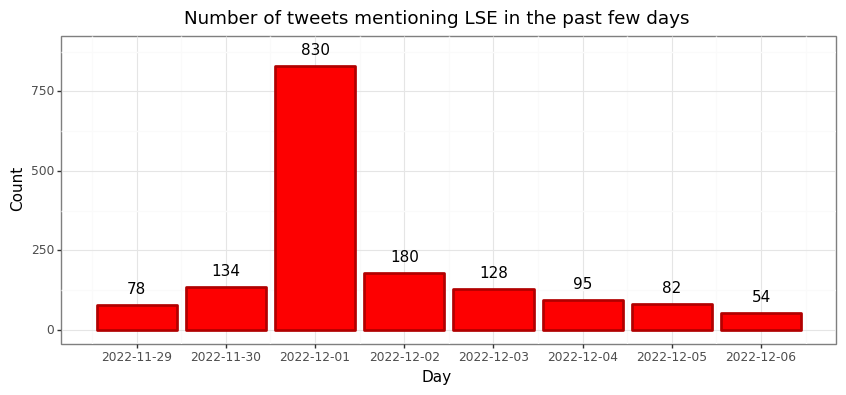

<ggplot: (109875002621)>

In [146]:
plot_df = (
     df.groupby(pd.Grouper(key="created_at", freq='1D'))
       .apply(lambda x: pd.Series({"count": len(x), "pctg": f"{100*(len(x)/df.shape[0]):.2f} %"})).reset_index()
)

g = (
    ggplot(plot_df, aes(x="created_at", y="count", label="count"))
    + geom_col(fill="#fd0001", color="#b10000", size=1.1)
    + geom_text(aes(y="count+50"))

    + theme_bw()
    + theme(figure_size=[10, 4]) 
    + labs(x="Day", y="Count", title="Number of tweets mentioning LSE in the past few days")
)

g

**How many tweets are "conversation starters"? That is, tweets that are not replies or retweets**

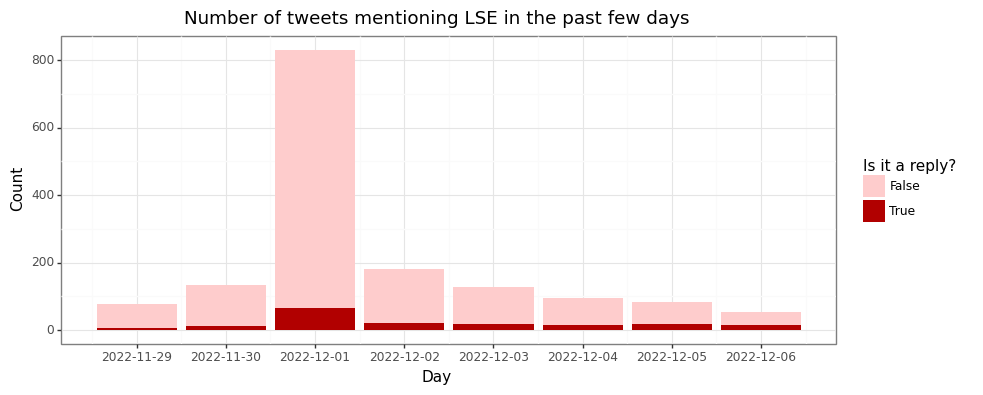

<ggplot: (109876090016)>

In [150]:
plot_df = (
     df.assign(is_reply=lambda x: ~np.isnan(x['in_reply_to_user_id']))
       .groupby([pd.Grouper(key="created_at", freq='1D'), "is_reply"])
       .apply(lambda x: pd.Series({"count": len(x), "pctg": f"{100*(len(x)/df.shape[0]):.2f} %"})).reset_index()
)

g = (
    ggplot(plot_df, aes(x="created_at", y="count", fill="is_reply"))
    + geom_col()

    # Set colors manually
    + scale_fill_manual(name="Is it a reply?", values=["#fecccc", "#b10000"])
    + theme_bw()
    + theme(figure_size=[10, 4]) 
    + labs(x="Day", y="Count", title="Number of tweets mentioning LSE in the past few days")
)

g

**What does that mean in numbers?**

In [153]:
df.assign(is_reply=lambda x: ~np.isnan(x['in_reply_to_user_id']))["is_reply"].value_counts()

False    1410
True      171
Name: is_reply, dtype: int64

# A simple network

**Who are the usernames involved in our data?**

In [213]:
all_author_ids = df["author_id"].unique()
users_in_reply = df["in_reply_to_user_id"].unique()[1:]

In [216]:
all_authors = list(set(all_author_ids).union(users_in_reply))
len(all_authors)

1569

**Twitter API will not let me consult info about all of these people quickly. So let me show you a simpler/smaller example.**

## A network of replies

Let's create a "reply" network. We will not have a lot of data but this should be easy enough to illustrate how to create a network.

In [223]:
df[["author_id", "in_reply_to_user_id"]].dropna()

,author_id,in_reply_to_user_id
0,1213119612478296070,-1
1,267809886,1329223582891737088
2,1511978625519820800,2331841448
3,1379847741094961162,-1
4,1093021616093708288,-1
...,...,...
1568,940224440,-1
1569,77174319,-1
1570,48548972,-1
1571,843245260088229890,-1


In [249]:
df_network = df[["author_id", "in_reply_to_user_id"]].query("in_reply_to_user_id != -1").dropna()

In [250]:
# df_network["author_id"] = df_network["author_id"].astype(str)
# df_network["in_reply_to_user_id"] = df_network["in_reply_to_user_id"].astype(str)

**Let's do something similar to what we did last week and combine all author ids**

In [251]:
unique_authors = list(set(df_network["author_id"]).union(set(df_network["in_reply_to_user_id"])))
len(unique_authors)

270

**Now, let's do the same we did last week and grab the authors' @**

In [255]:
first_usernames  = client.get_users(ids=unique_authors[0:100])
second_usernames = client.get_users(ids=unique_authors[100:200])
third_usernames = client.get_users(ids=unique_authors[201:])

In [262]:
all_users_returned = first_usernames.data + second_usernames.data + third_usernames.data

In [277]:
def extract_user_data(user):
    
    return pd.DataFrame({"name": user.name, "username" : f"@{user.username}"},index=[user.id])

df_user_info = pd.concat([extract_user_data(user) for user in all_users_returned])
df_user_info

,name,username
1511978625519820800,nope.jpg,@nopejpg4
1518715324392251393,BernVan,@BVanGogh13
1360444064361979906,Chocosuckao,@chocosuckao
1514014426525220866,CHOLE_CHAN,@CHOLECHAN8
1023068569209397248,pnmasonuk,@pnmasonuk
...,...,...
186434548,Abiola,@Mowizz_BMG
8302582,Javier F. Barrera,@juanlarzabal
429902840,Haroun Rashid,@HarounRashid2
58436094,Marina Purkiss,@MarinaPurkiss


**Who follows who?**

In [ ]:
client.get_users_followers

# Extract tokens

Tokenisation is the process of segmenting text into words, punctuations marks etc.

We are going to use spaCy

## Which languages are involved?

In [42]:
df["lang"].value_counts()

en    49
el    43
es     5
in     2
de     1
Name: lang, dtype: int64

Check twitter API Documentation to check the languages: https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages

## Let's focus on language='en' first

In [43]:
# Pick one random sample
sample = df.query("lang == 'en'").sample(1)

sample

,author_id,text,created_at,lang,author_username
57,1586632345129742336,"he waged\na relentless, lifelong struggle for ...",2022-11-29 10:05:46+00:00,en,MadrasTribes


In [45]:
just_the_text = sample["text"].values[0]
print(just_the_text)

he waged
a relentless, lifelong struggle for the rights of Dalits. Having
earned doctorates from both Columbia University and the
London School of Economics, went on to serve as Chairman
of the Drafting Committee of the Indian Constitution.

(2)


🗣️ **CLASSROOM DISCUSSION:** What does the following represent?

In [46]:
len(just_the_text)

245

In [47]:
type(just_the_text)

str

### Tokenization

**We need to load the language related features from spaCy**

In [48]:
from spacy.lang.en import English
language_parser = English()

tokenized_text = language_parser(just_the_text)
type(tokenized_text)

  0%|                                                               | 0/98 [12:26<?, ?it/s]


spacy.tokens.doc.Doc

In [49]:
tokenized_text

he waged
a relentless, lifelong struggle for the rights of Dalits. Having
earned doctorates from both Columbia University and the
London School of Economics, went on to serve as Chairman
of the Drafting Committee of the Indian Constitution.

(2)

🗣️ **CLASSROOM DISCUSSION:** What do you think the following represents?

In [50]:
len(tokenized_text)

50

In [222]:
for token in tokenized_text:
    print(token)

RT
@BrexitBin
:
In
case
you
missed
it
...


Here
's
an
excerpt
from
a
report
into
immigration
and
wages
by
the
London
School
of
Economics
.
It
s
…


**Silly way to count repeated tokens using `list comprehension`**

In [51]:
pd.Series([token for token in tokenized_text]).value_counts()

he              1
of              1
of              1
Economics       1
,               1
went            1
on              1
to              1
serve           1
as              1
Chairman        1
\n              1
the             1
waged           1
Drafting        1
Committee       1
of              1
the             1
Indian          1
Constitution    1
.               1
\n\n            1
(               1
2               1
School          1
London          1
\n              1
the             1
\n              1
a               1
relentless      1
,               1
lifelong        1
struggle        1
for             1
the             1
rights          1
of              1
Dalits          1
.               1
Having          1
\n              1
earned          1
doctorates      1
from            1
both            1
Columbia        1
University      1
and             1
)               1
dtype: int64

**Let's change everything to lowercase:**

In [224]:
new_tokenized_test = language_parser(just_the_text.strip().lower())

pd.Series([token for token in new_tokenized_test]).value_counts()

rt             1
report         1
s              1
it             1
.              1
economics      1
of             1
school         1
london         1
the            1
by             1
wages          1
and            1
immigration    1
into           1
a              1
@brexitbin     1
from           1
excerpt        1
an             1
's             1
here           1
\n             1
...            1
it             1
missed         1
you            1
case           1
in             1
:              1
…              1
dtype: int64

### Lemmatization

https://spacy.io/usage/linguistic-features#lemmatization

There are **pre-trained** fancy NLP models that can detect more interesting things about our text.

In [235]:
# You need to download the suitable NLP models https://spacy.io/models/en
#!python -m spacy download en_core_web_sm

In [53]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [57]:
fancier_tokenized_text = nlp(just_the_text.strip().lower())

fancier_tokenized_text[1].lemma_

'wage'

In [63]:
my_tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in fancier_tokenized_text ]

### Remove punctuation & stop words

In [64]:
import string

from spacy.lang.en.stop_words import STOP_WORDS

# Create our list of punctuation marks
punctuations = string.punctuation

# Stop words for the English language
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Removing stop words
my_tokens = [ word for word in my_tokens if word not in stop_words and word not in punctuations ]
my_tokens

['wage',
 'relentless',
 'lifelong',
 'struggle',
 'right',
 'dalit',
 'having',
 'earn',
 'doctorate',
 'columbia',
 'university',
 'london',
 'school',
 'economic',
 'serve',
 'chairman',
 'drafting',
 'committee',
 'indian',
 'constitution',
 '2']

In [243]:
len(my_tokens)

17

## Putting everything together: automating this process

Also, check [this tutorial](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/)

In [66]:
import string

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def clean_text(tweet_text):
    simpler_text = tweet_text.strip().lower()
    mytokens = nlp(simpler_text)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

Use pandas `apply` to make your code look cleaner!

In [70]:
df_en = df.query("lang == 'en'")

In [71]:
df_en["text"].apply(clean_text)

7     [rt, @pleaseletmevote, london, school, economi...
17    [director, international, programme, impact, l...
18    [tax, cut, wealthy, long, draw, support, conse...
23    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
25    [rt, @fascinatorfun, loss, 20, pound, value, d...
32    [rt, @tanzania_epza, y'day, courtesy, visit, c...
33    [director, international, programme, impact, l...
34    [rt, @fascinatorfun, loss, 20, pound, value, d...
35    [london, school, economic, estimate, brexit, –...
36    [rt, @fascinatorfun, loss, 20, pound, value, d...
37    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
39    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
40    [london, school, economic, estimate, brexit, ....
41    [andy, vermaut, share, finance, employee, futu...
42    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
43    [rt, @fascinatorfun, loss, 20, pound, value, d...
44    [rt, @fascinatorfun, loss, 20, pound, value, d...
45    [📢, pleased, award, 2022, latin, american,

**There is a fancy tqdm for pandas**

In [72]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [73]:
df_en["text"].progress_apply(clean_text)

100%|██████████████████████████████████████████████████████| 49/49 [00:01<00:00, 39.23it/s]


7     [rt, @pleaseletmevote, london, school, economi...
17    [director, international, programme, impact, l...
18    [tax, cut, wealthy, long, draw, support, conse...
23    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
25    [rt, @fascinatorfun, loss, 20, pound, value, d...
32    [rt, @tanzania_epza, y'day, courtesy, visit, c...
33    [director, international, programme, impact, l...
34    [rt, @fascinatorfun, loss, 20, pound, value, d...
35    [london, school, economic, estimate, brexit, –...
36    [rt, @fascinatorfun, loss, 20, pound, value, d...
37    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
39    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
40    [london, school, economic, estimate, brexit, ....
41    [andy, vermaut, share, finance, employee, futu...
42    [rt, @lag_uk, 📢, pleased, award, 2022, latin, ...
43    [rt, @fascinatorfun, loss, 20, pound, value, d...
44    [rt, @fascinatorfun, loss, 20, pound, value, d...
45    [📢, pleased, award, 2022, latin, american,

# Now what

Now that you have cleaned and tokenized everything, you can do the fun stuff:

## Bag of Words 

Use `CountVectorizer` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) package to create a bag of words

In [74]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vector = CountVectorizer(tokenizer = clean_text, ngram_range=(1,1))

In [75]:
bow_vector.fit_transform(df.query("lang == 'en'")["text"])

<49x321 sparse matrix of type '<class 'numpy.int64'>'
	with 806 stored elements in Compressed Sparse Row format>

In [76]:
bow_vector.fit_transform(df.query("lang == 'en'")["text"]).todense().shape

(49, 321)

In [259]:
#bow_vector.get_feature_names_out()

In [77]:
df_bag_words = pd.DataFrame(bow_vector.fit_transform(df.query("lang == 'en'")["text"]).todense(),
                            columns=bow_vector.get_feature_names_out())

In [78]:
df_bag_words

,..,...,.....,01,08:46,1/3,16,1947,1951,1954,...,workin,world,wraptite,y'day,year,–,—,…,🌍,📢
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
l

**What are the most frequent tokens?**

In [79]:
df_bag_words.sum().sort_values(ascending=False).head(10)

london      45
school      44
economic    39
…           28
rt          28
20          12
brexit      12
loss        12
value       12
pound       12
dtype: int64

🗣️ **CLASSROOM DISCUSSION** What would you do with this data now?

### PCA + plotly

In [268]:
!pip install plotly==5.11.0

^C


In [271]:
## Train an algorithm called PCA

## Read more about it here https://scikit-learn.org/stable/modules/decomposition.html#pca

from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(df_bag_words)

In [304]:
df_pca = pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(components.shape[1])])